# AVN Syllable Segmentation Tutorial

In [1]:
import avn.dataloading
import avn.segmentation

## Simple Segmentation

In this section of the tutorial, I will be segmenting 50 song files from a single bird using MFCC derivative threshold segmentation. First, let's specify the path to the folder containing the song files:


In [2]:
Bird_ID = "G402"
song_folder = "../sample_data/" + Bird_ID + "/"

Now, we will instantiate an MFCCDerivative class object, which we will then use for segmentation. Segmentation using other criteria will differ in terms of which segmenter is used. Currently the options available are RMSE, RMSEDerivative, MFCC and MFCCDerivative. 

In [3]:
segmenter = avn.segmentation.MFCCDerivative()

Now that we've created the segmenter, we can use it to segment the songs in `song_folder`. We must also specify the value of the upper and lower segmentation thresholds. 

In [4]:
seg_data = segmenter.make_segmentation_table(Bird_ID, song_folder, 
                                            upper_threshold = 0.10, 
                                            lower_threshold = -0.1)

`seg_data` is an instance of the avn.segmentation.SegData class. It's `.seg_table` attribute contains a dataframe with the onset and offset times of every syllable, generated by `segmenter`:

In [5]:
seg_data.seg_table.head()

onsets   offsets                                 files
0  0.359909  0.522449  G402_43362.23322048_9_19_6_28_42.wav
1  0.522449  0.766259  G402_43362.23322048_9_19_6_28_42.wav
2  0.766259  0.882358  G402_43362.23322048_9_19_6_28_42.wav
3  0.882358  1.021678  G402_43362.23322048_9_19_6_28_42.wav
4  1.021678  1.160998  G402_43362.23322048_9_19_6_28_42.wav

These syllable onset and offset timestamps can be used to extract individual syllables from files for further analyses, like syllable labeling or calculating acoustic features. To save this table locally for future use you can use the following function: 

In [6]:
out_file_dir = "../sample_data/"
seg_data.save_as_csv(out_file_dir)

This will create a file called `[Bird_ID]_seg_table.csv`. In our case, that is "G402_seg_table.csv"

## Selecting a Threshold

In the example above, we used an upper_threshold value of 0.1. This threshold generally works well for MFCC derivative segmentation across all zebra finches, in my experience, but you may want to test other thresholds to see how they compare. 


### Automatic Threshold Optimization

If you have ground truth segmentation data generated in evsonganaly and exported to a .csv file using `generate_syll_table_TK()` in MATLAB, then you can use avn's in-build threshold optimization functions. You must specify a range of threshold values to test and the step between thresholds, and the function will return the threshold from that set which yields the highest F1 score: 

In [12]:
ground_truth_data_path = "../sample_data/" + Bird_ID + "/" + Bird_ID + "_syll_table.csv"

optimal_threshold, peak_F1, segmentation_scores = avn.segmentation.Utils.threshold_optimization(segmenter, Bird_ID, 
                                                                                               song_folder, 
                                                                                               ground_truth_data_path, 
                                                                                               threshold_range = (0.08, 0.13), 
                                                                                               threshold_step = 0.01, 
                                                                                               lower_threshold = -0.01)
print("The optimal threshold is: " + str(optimal_threshold))
print("The F1 score at the optimal threshold is: " + str(peak_F1))

The optimal threshold is: 0.11999999999999998
The F1 score at the optimal threshold is: 0.9711078777800873


`segmentation_scores` contains all the segmentation accuracy metrics calculated at each threshold tested:

In [13]:
segmentation_scores

F1  precision    recall  upper_threshold  lower_threshold
0  0.918155   0.853961  0.992784             0.08            -0.01
0  0.937287   0.887666  0.992784             0.09            -0.01
0  0.949675   0.911570  0.991105             0.10            -0.01
0  0.961380   0.934132  0.990267             0.11            -0.01
0  0.971108   0.954248  0.988574             0.12            -0.01

### Manual Threshold Selection

If you do not have 'ground truth' segmentation data (which is necessary to calculate F1 scores, and thus to perform automatic threshold optimization), you can use AVN's plotting functions to estimate the best threshold and look at the resulting segmentations. 

First, plot the MFCC Derivative of an example file over it's spectrogram: 

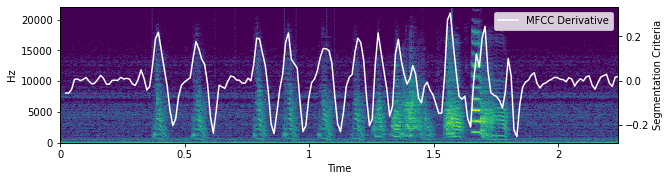

<Figure size 1440x360 with 0 Axes>

In [14]:
avn.segmentation.Plot.plot_seg_criteria(seg_data, segmenter, "MFCC Derivative")

From this example, we can see that setting a threshold around 0.1 should yield good segmentation, as the MFCC derivative appears to cross 0.1 around every syllable onset, but doesn't cross 0.1 at any other times. 

To be sure, it can be good to look at multiple example files. You can change which example is displayed by changing the `file_idx` argument to `avn.segmentation.Plot.plot_seg_criteria()`:

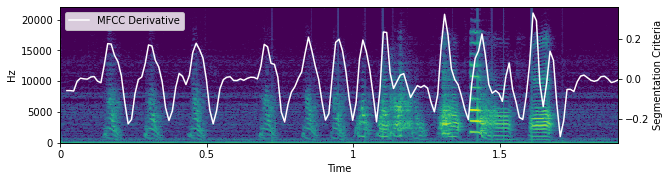

<Figure size 1440x360 with 0 Axes>

In [17]:
avn.segmentation.Plot.plot_seg_criteria(seg_data, segmenter, "MFCC Derivative", file_idx = 1)

Now that we are somewhat confident with a threshold of 0.1, we can use that threshold to generate a `SegData` object (which we have already done in the first section of this tutorial) and plot the resulting segmentations over the spectrogram using `avn.segmentation.Plot.plot_segmentations()`:

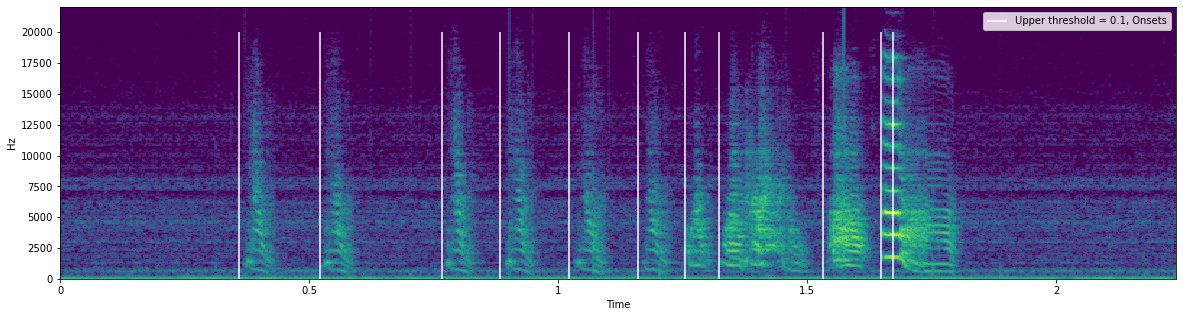

In [7]:
avn.segmentation.Plot.plot_segmentations(seg_data, seg_label = "Upper threshold = 0.1, Onsets")

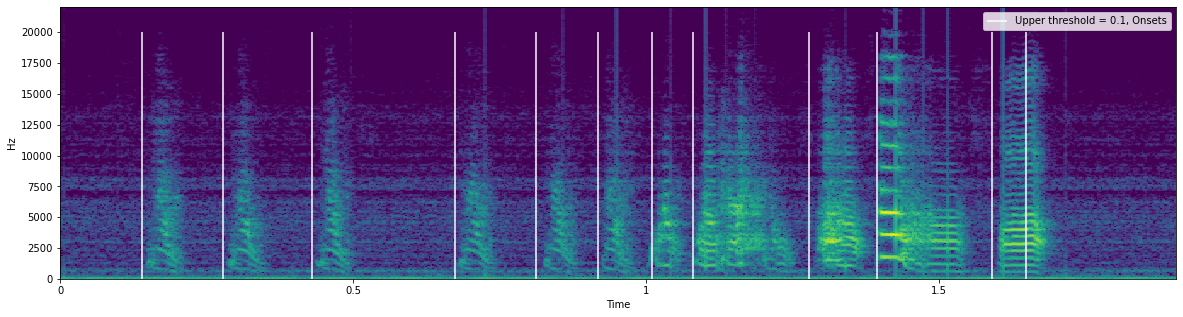

In [18]:
avn.segmentation.Plot.plot_segmentations(seg_data, seg_label = "Upper threshold = 0.1, Onsets", file_idx = 1)

The white lines in the spectrogram above represent the syllable onset times. 

We can test other segmentation thresholds by generating new `SegData` objects and plotting them as well: 

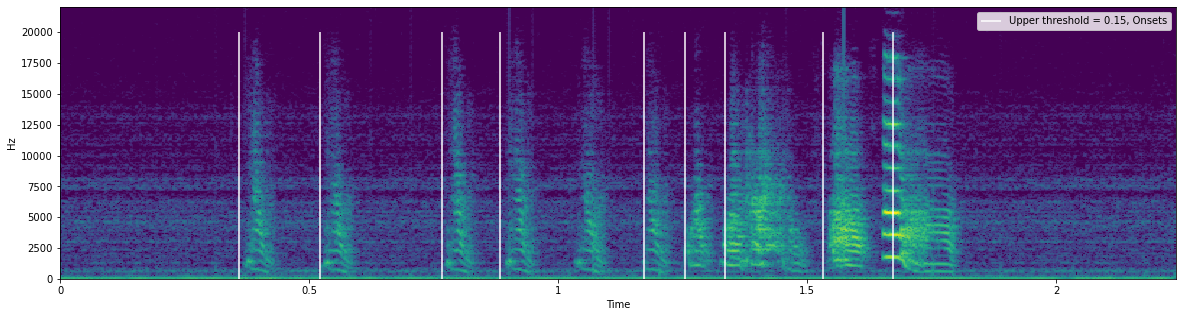

In [20]:
seg_data_015 = segmenter.make_segmentation_table(Bird_ID, song_folder,
                                                upper_threshold = 0.15, 
                                                lower_threshold = -0.01)

avn.segmentation.Plot.plot_segmentations(seg_data_015, seg_label = "Upper threshold = 0.15, Onsets")

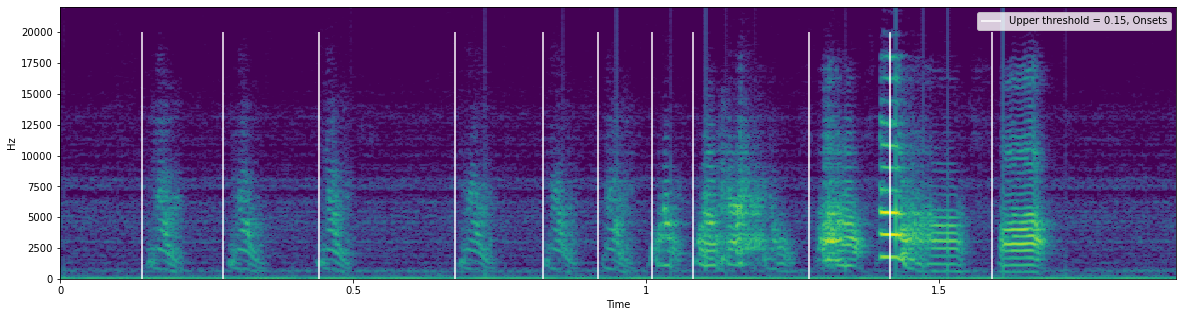

In [21]:
avn.segmentation.Plot.plot_segmentations(seg_data_015, seg_label = "Upper threshold = 0.15, Onsets", file_idx = 1)

## Calculating Segmentation Metrics

If you have 'ground truth' segmentation data in the correct format, you can also use it to calculate the segmentation accuracy at a single given threshold. First, you must load the true segmentation data from memory, then you can calculate the F1 score, precision, and recall: 

In [24]:
ground_truth_data_path = "../sample_data/" + Bird_ID + "/" + Bird_ID + "_syll_table.csv"

seg_data = avn.dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_data_path)

This added the ground truth segmentation data to the `.true_seg_table` attribute of `seg_data` in the same format as the `.seg_table` avn generated segmentations: 

In [26]:
seg_data.true_seg_table.head()

files labels    onsets   offsets
0  G402_43362.23322048_9_19_6_28_42.wav      s  0.370544  0.429705
1  G402_43362.23322048_9_19_6_28_42.wav      s  0.525578  0.590363
2  G402_43362.23322048_9_19_6_28_42.wav      s  0.774830  0.831293
3  G402_43362.23322048_9_19_6_28_42.wav      s  0.894898  0.956372
4  G402_43362.23322048_9_19_6_28_42.wav      s  1.032925  1.103447

Now that the we have the ground truth data, we can calculate the metrics: 

In [28]:
seg_data = avn.segmentation.Metrics.calc_F1(seg_data)

This added the metrics information to `seg_data` in it's `.seg_metrics` attribute:

In [29]:
seg_data.seg_metrics

F1  precision    recall
0  0.949675    0.91157  0.991105

If you want to save this information locally, along with the avn generated segmentation table, you can run the following: 

In [30]:
out_file_dir = "../sample_data/"
seg_data.save_as_csv(out_file_dir)

This will create two files in the `out_file_dir` folder: 
- `[Bird_ID]_seg_table.csv` containing the avn generated segmentations 
- `[Bird_ID]_seg_metrics.csv` containing the segmentation metrics. 

## Segmenting Many Birds at Once

Often, you'll want to segment the data of many birds. AVN has built in utility functions to make this easy if you have your data arranged in the compatible configuration. In order to use the following functions, you must have a master folder which contains a subfolder corresponding to each bird, with the folders named with the Bird's ID. Each bird folder must contain all the .wav files to be segmented for that bird directly (ie not in a subfolder). 

If that is the case, you can specify the list of Bird_IDs that you want to segment and go through the following steps: 

In [32]:
Bird_IDs = ['G402', 'R402']

song_folder = "../sample_data/"

segmenter = avn.segmentation.MFCCDerivative()

seg_table = avn.segmentation.Utils.make_segmentation_table_many_birds(segmenter, Bird_IDs, 
                                                                     song_folder, 
                                                                     upper_threshold = 0.1, 
                                                                     lower_threshold = -0.01)
seg_table.head()


onsets   offsets                                 files Bird_ID
0  0.359909  0.522449  G402_43362.23322048_9_19_6_28_42.wav    G402
1  0.522449  0.766259  G402_43362.23322048_9_19_6_28_42.wav    G402
2  0.766259  0.882358  G402_43362.23322048_9_19_6_28_42.wav    G402
3  0.882358  1.021678  G402_43362.23322048_9_19_6_28_42.wav    G402
4  1.021678  1.160998  G402_43362.23322048_9_19_6_28_42.wav    G402

If you have the correctly formatted ground truth segmentation data for each bird saved in that bird's subdirectory and named `[Bird_ID]_syll_table.csv`, you can also calculate the segmentation metrics for many birds at once:

In [36]:
segmentation_scores, seg_table = avn.segmentation.Utils.calc_F1_many_birds(segmenter, Bird_IDs, song_folder, 
                                                                      upper_threshold = 0.1, 
                                                                      lower_threshold = -0.01)
segmentation_scores

F1  precision    recall  upper_threshold  lower_threshold Bird_ID
0  0.949675   0.911570  0.991105              0.1            -0.01    G402
0  0.979268   0.971979  0.986667              0.1            -0.01    R402

Likewise, you can perform threshold optimization, looking for the single threshold that results in the highest mean F1 score across birds: 

In [37]:
optimal_threshold, peak_mean_F1, segmentation_scores = avn.segmentation.Utils.threshold_optimization_many_birds(segmenter, 
                                                                                                               Bird_IDs, 
                                                                                                               song_folder, 
                                                                                                               threshold_range = (0.08, 0.13), 
                                                                                                               threshold_step = 0.01, 
                                                                                                               lower_threshold = -0.01)
print("The optimal threshold is: " + str(optimal_threshold))
print("The mean F1 score at the optimal threshold is: " + str(peak_mean_F1))

The optimal threshold is: 0.11999999999999998
The mean F1 score at the optimal threshold is: 0.9689321958532062


You can also plot the segmentations of many birds: 

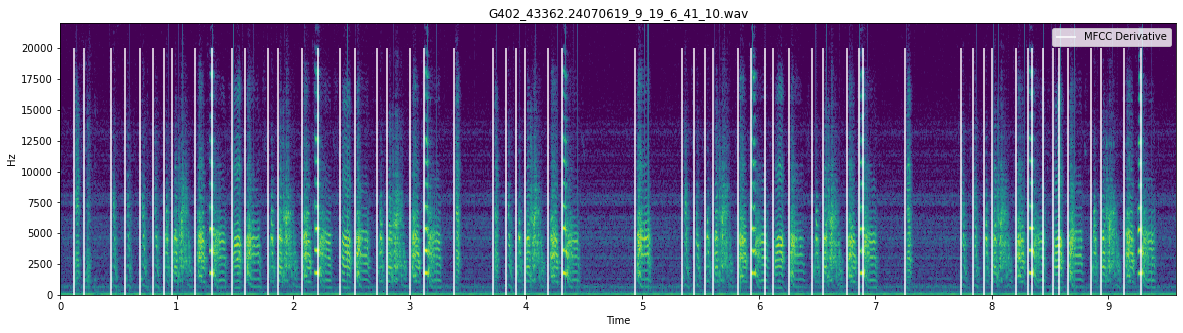

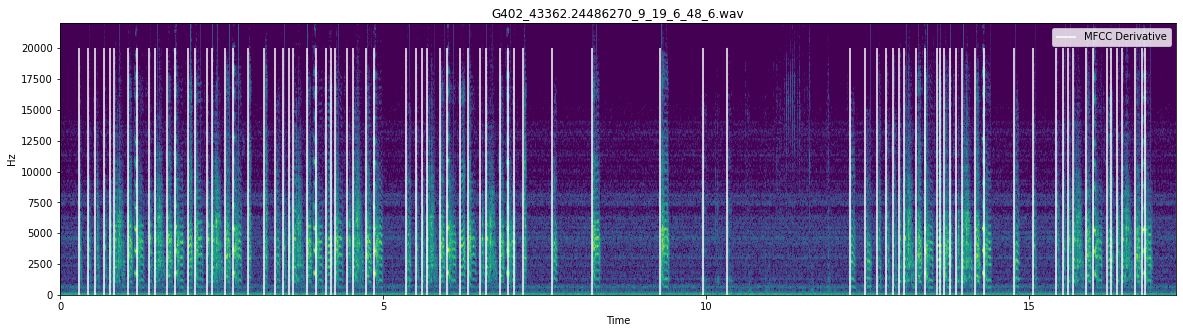

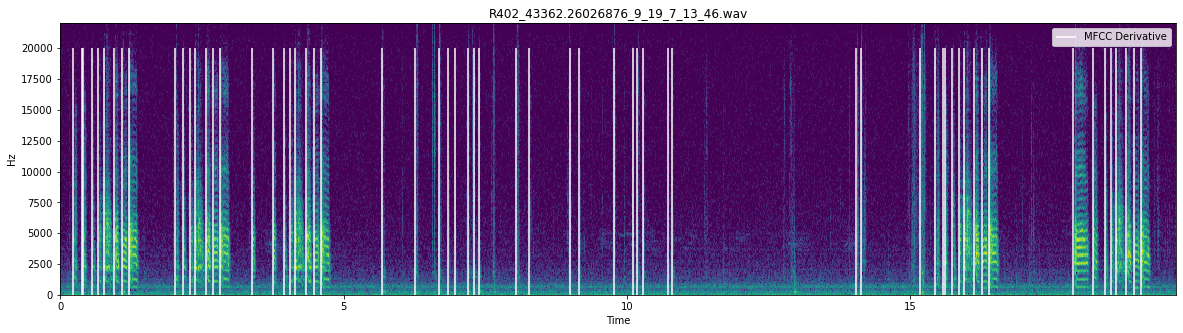

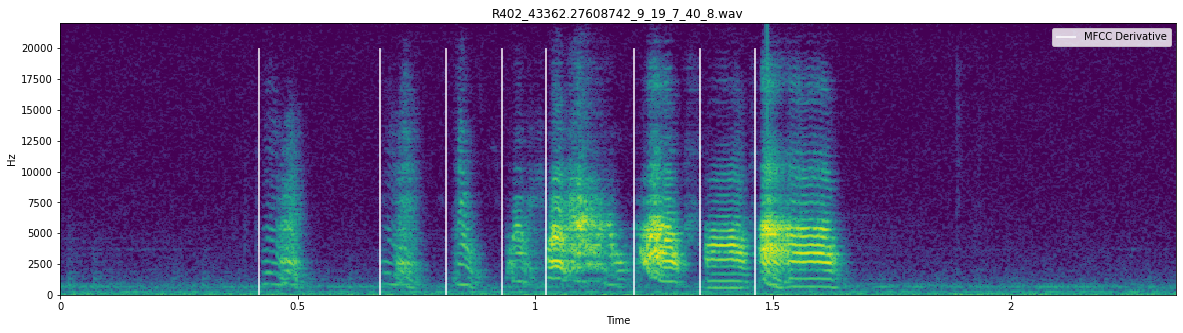

In [39]:
avn.segmentation.Utils.plot_segmentations_many_birds(segmenter, Bird_IDs, 
                                                    song_folder, 
                                                    seg_label = "Syllable Onset", 
                                                    upper_threshold = 0.1, 
                                                    lower_threshold = -0.01, 
                                                    files_per_bird = 2)